# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Ознакомление с данными

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
# импортируем необходимые библиотеки

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
# читаем датасет
df.info()
# смотрим общую информацию о датасете

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 3214 entries, 0 to 3213

Data columns (total 5 columns):

 #   Column    Non-Null Count  Dtype  

---  ------    --------------  -----  

 0   calls     3214 non-null   float64

 1   minutes   3214 non-null   float64

 2   messages  3214 non-null   float64

 3   mb_used   3214 non-null   float64

 4   is_ultra  3214 non-null   int64  

dtypes: float64(4), int64(1)

memory usage: 125.7 KB


In [3]:
df.head()
# выводим первые пять строк датасета для ознакомления

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.describe()
# смотрим информацию о данных датасета

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [5]:
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Вывод. 

Поскольку преобработка уже проведена, пропусков и других проблем с данными нет, можно брать их в работу. Выборка не очень большая, но какая есть. Количество абонентов на тарифе Ультра в 2 раза ниже, чем на тарифе, Смарт. Надо при разделении на выборки будет учесть этот момент, чтобы во всех 3-х выборках сохранилось соотношение.

## Подготовка обучающей, валидационной и тестовой выборок

In [8]:
df_train_max, df_test = train_test_split(df, test_size=0.20, random_state=12345, stratify=df['is_ultra'])
# разделяем датасет на два - тренировочный и тестовый

In [9]:
df_train_max['is_ultra'].value_counts()

0    1783
1     788
Name: is_ultra, dtype: int64

In [10]:
df_train_max.shape
# смотрим на размер тренировочного датасета

(2571, 5)

In [11]:
features_train_max = df_train_max.drop(['is_ultra'], axis=1)
target_train_max = df_train_max['is_ultra']
# готовим параметры для обучения

In [12]:
df_train, df_valid = train_test_split(df_train_max, test_size=0.25, random_state=12345, stratify=df_train_max['is_ultra'])
# разделяем тренировочный датасет на 2 - на сам тренировочный и валидационный

In [13]:
df_train['is_ultra'].value_counts()

0    1337
1     591
Name: is_ultra, dtype: int64

In [14]:
df_train.shape
# смотрим на размер нового тренировочного датасета

(1928, 5)

In [15]:
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']
# готовим параметры для обучения

In [16]:
df_valid.shape
# смотрим на размер валидационного датасета

(643, 5)

In [17]:
df_valid['is_ultra'].value_counts()

0    446
1    197
Name: is_ultra, dtype: int64

In [18]:
features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']
# готовим параметры для валидации

In [19]:
df_test.shape
# смотрим на размер тестового датасета

(643, 5)

In [20]:
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']
# готовим параметры для теста

Вывод. 

Подготовили три выборки - для обучения (самую крупную), валидациb и тестовую (одинакового размера). Также в выборках подготовили необходимые параметры.

## Исследование моделей

### Модель "Дерево решений"

In [21]:
best_model_dt = None
best_result_dt = 0
accuracy = []
depth_x = []
for depth in range(1, 21):
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dt.fit(features_train, target_train)
    predictions_valid = model_dt.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    accuracy.append(result)
    depth_x.append(depth)
    if result > best_result_dt:
        best_model_dt = model_dt
        best_result_dt = result
    print("max_depth =", depth, ": ", end='')
    print(accuracy_score(target_valid, predictions_valid))
# делаем цикл, которые подберёт лучшие гиперпараметры для модели

max_depth = 1 : 0.7589424572317263

max_depth = 2 : 0.7838258164852255

max_depth = 3 : 0.8040435458786936

max_depth = 4 : 0.8040435458786936

max_depth = 5 : 0.8164852255054432

max_depth = 6 : 0.80248833592535

max_depth = 7 : 0.807153965785381

max_depth = 8 : 0.8055987558320373

max_depth = 9 : 0.8118195956454122

max_depth = 10 : 0.8055987558320373

max_depth = 11 : 0.807153965785381

max_depth = 12 : 0.7853810264385692

max_depth = 13 : 0.7869362363919129

max_depth = 14 : 0.7838258164852255

max_depth = 15 : 0.7791601866251944

max_depth = 16 : 0.76049766718507

max_depth = 17 : 0.7511664074650077

max_depth = 18 : 0.7465007776049767

max_depth = 19 : 0.7511664074650077

max_depth = 20 : 0.7465007776049767


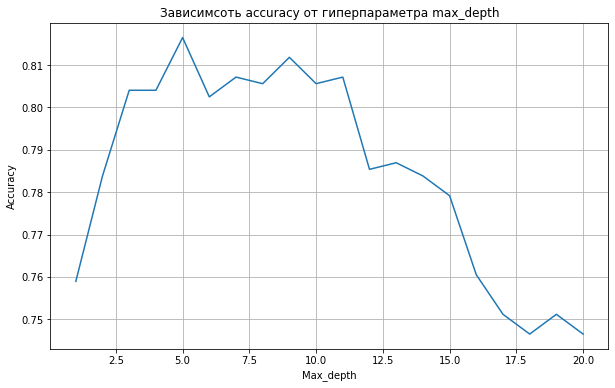

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(depth_x, accuracy)
plt.xlabel('Max_depth')
plt.ylabel('Accuracy')
plt.title('Зависимсоть accuracy от гиперпараметра max_depth')
plt.grid(True)

Вывод. 

Наибольший accuracy показывает модель с гиперпараметром depth, равном 5. Дальше, как видно по графику, происходит переобучение модели.

### Модель "Случайный лес"

In [23]:
best_model_rf = None
best_result_rf = 0
for est in range(1, 11):
    model_rf = RandomForestClassifier(random_state=12345, n_estimators=est)
    model_rf.fit(features_train, target_train)
    result = model_rf.score(features_valid, target_valid)
    if result > best_result_rf:
        best_model_rf = model_rf
        best_result_rf = result
    print("max_est =", est, ": ", end='')
    print(model_rf.score(features_valid, target_valid))  
# делаем цикл, которые подберёт лучшие гиперпараметры для модели

max_est = 1 : 0.7340590979782271

max_est = 2 : 0.7713841368584758

max_est = 3 : 0.7465007776049767

max_est = 4 : 0.7884914463452566

max_est = 5 : 0.7776049766718507

max_est = 6 : 0.7962674961119751

max_est = 7 : 0.7978227060653188

max_est = 8 : 0.7962674961119751

max_est = 9 : 0.8009331259720062

max_est = 10 : 0.8133748055987559


In [34]:
rfc = RandomForestClassifier()
param_grid = { 
    'n_estimators': range(1, 21),
    'max_depth': range(1, 21)
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(features_train_max, target_train_max)
print(CV_rfc.best_params_)
# пробуем подобрать лучшие гиперпараметры методом GridSearch

{'max_depth': 9, 'n_estimators': 15}


In [37]:
rfc_dt_best = RandomForestClassifier(random_state=12345, n_estimators=13, max_depth=10)
rfc_dt_best.fit(features_train_max, target_train_max)
rfc_dt_best.score(features_test, target_test)

0.8195956454121306

Вывод. 

Наибольший accuracy показывает модель с гиперпараметром n_estimators, равном 10.

### Модель "Логистическая регрессия"

In [26]:
model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_lr.fit(features_train, target_train)
model_lr.score(features_valid, target_valid)
# создаём модель и смотрим на её accuracy

0.7558320373250389

Вывод. 

Ну тут гиперпараметры сложно перебирать, поэтому просто обучаем и запускаем модель с рекомендуемыми.

### Вывод.

Наилучшее значение accuracy(0,81) показывает модель "Дерево решений" со значением max_depth=5, её и берём как основную.

## Проверка модели на тестовой выборке

### Модель "Дерево решений"

In [27]:
model_dt_best = DecisionTreeClassifier(random_state=12345, max_depth=5)
model_dt_best.fit(features_train, target_train)
model_dt_best.score(features_test, target_test)

0.7962674961119751

Проверили модель с гиперпараметром, который показал наилучшие результаты на валидационной выборке.

Интересно, что на тестовой выборке наша модель показала пусть и ненамного, но хуже значение accuracy, чем на валидационной.

### Вывод.

Все три модели показали значение accuracy более 0,75, поэтому задачу можно считать выполненной.

На тестовой выборке наилучший результат accuracy показала модель "Дерево решений", что несколько неожиданно, т.к. она считается более простой и менее точной, чем тот же "Случайный лес". Возможно, при большей обучающей выборке или более тонкой настройке гиперпараметров модели она показала бы лучшие результаты. 

На основе проведённого исследования можно рекомендовать модель "Дерево решений" со значением гиперпараметра max_depth=5 для дальнейшей работы.

Использовать данную модель в дальнейшем мы можем, например, анализируя то, как пользуются услугами другие абоненты (сколько минут говорят, какое количество смс отправляют и Гб интернет-трафика используют). Модель поможет нам рекомендовать абонентам наиболее подходящий под их сценарий использования тариф. Если абонент пользуется услугами много, будем предлагать ему более дорогой тариф, который будет приносить больше выручки для компании.

### Проверка модели на адекватность

Для сравнения, посмотрим какие результаты показывает базовая модель классификации при обучении на нашем обучающей выборке и какое значение accuracy будет на тестовой выборке.

In [28]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=12345)
dummy_clf.fit(features_train, target_train)
dummy_clf.score(features_test, target_test)

0.6936236391912908

Вывод.

Из полученных данных видно, что наша модель показывает существенно лучшее значение accuracy (0,79), чем базовая (0,69), что говорит о том, что наш выбор модели и настройка её гиперпараметров оправданы.